In [20]:
''' 2) Use XML processing modules (https://docs.python.org/3/library/xml.html) to obtain 
 bounding box information from Annotations datasets and scikit-Image (Reference: 
 https://scikit-image.org/) to perform image processing and feature extraction. '''

# All imports
import os
import xml.etree.ElementTree as ET
from skimage import io, filters, exposure
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from skimage.feature import hog
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np, pandas as pd
import glob
import json

In [28]:
# (a) Cropping and resizing images

# Get x and y coordinates from annotations for bounding box information
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin, ymin, xmax, ymax))
    return bbox
    
# Get image path from annotation path
def get_image(annot):
    img_path = './images/'
    file = annot.split('\\')
    img_filename = img_path + file[-2] + '\\' + file[-1] + '.jpg' 
    return img_filename

# Cropping and resizing images using bounding box info
def crop_and_resize(images, annotations):
    for i in range(len(images)):
        bbox = get_bounding_boxes(annotations[i])
        dog = get_image(annotations[i])
        im = Image.open(dog)
        for j in range(len(bbox)):
            im2 = im.crop(bbox[j])
            im2 = im2.resize((128,128), Image.Resampling.LANCZOS)
            new_path = dog.replace('./images/', './Processed_Data/')
            new_path = new_path.replace('.jpg', '-' + str(j) + '.jpg')
            im2 = im2.convert('RGB')
            head, tail = os.path.split(new_path)
            Path(head).mkdir(parents=True, exist_ok=True)
            im2.save(new_path)

# File paths
images = glob.glob('./images/*/*')
annotations = glob.glob('./annotations/*/*')

# Call crop_and_resize to get processed images
crop_and_resize(images, annotations)

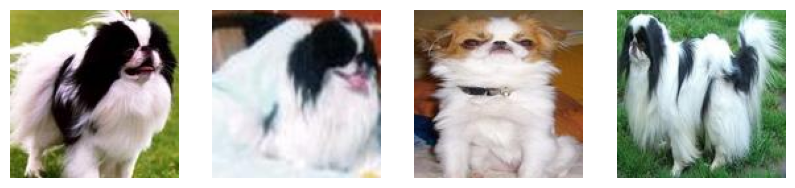

In [29]:
# Results from above:
processed = glob.glob('./Processed_Data/*/*')
plt.figure(figsize=(10,6))
for i in range(4):
    plt.subplot(1,4, i+1)
    plt.axis("off")
    im = Image.open(processed[i])
    plt.imshow(im)

# Processed images are all cropped and resized

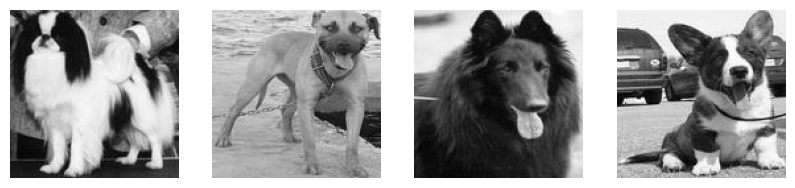

In [41]:
# (b) Feature extraction: Edge histogram and similarity measurements

# i. Choose one image from each class
chosen_images = ['Processed_Data/n02085782-Japanese_spaniel/n02085782_126-0.jpg',
                 'Processed_Data/n02093428-American_Staffordshire_terrier/n02093428_582-0.jpg',
                 'Processed_Data/n02105056-groenendael/n02105056_1061-0.jpg',
                 'Processed_Data/n02113186-Cardigan/n02113186_748-0.jpg']

#  ii. Convert color images to grayscale image
grayscale = []
for image_path in chosen_images:
    image = Image.open(image_path)
    image_array = np.array(image)
    gray = rgb2gray(image_array)
    grayscale.append(gray)

# Displaying results of turning 4 images to grayscale:
plt.figure(figsize=(10,6))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.axis("off")
    plt.imshow(grayscale[i], cmap=plt.cm.gray)
plt.show()

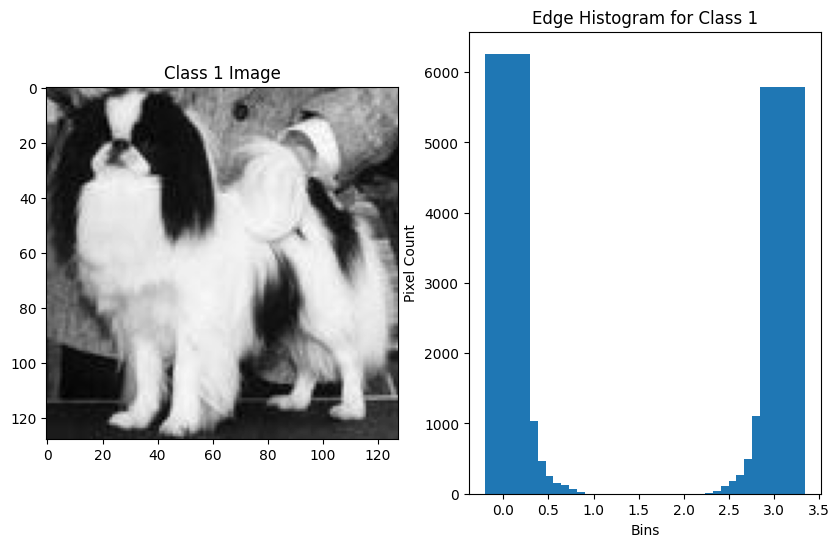

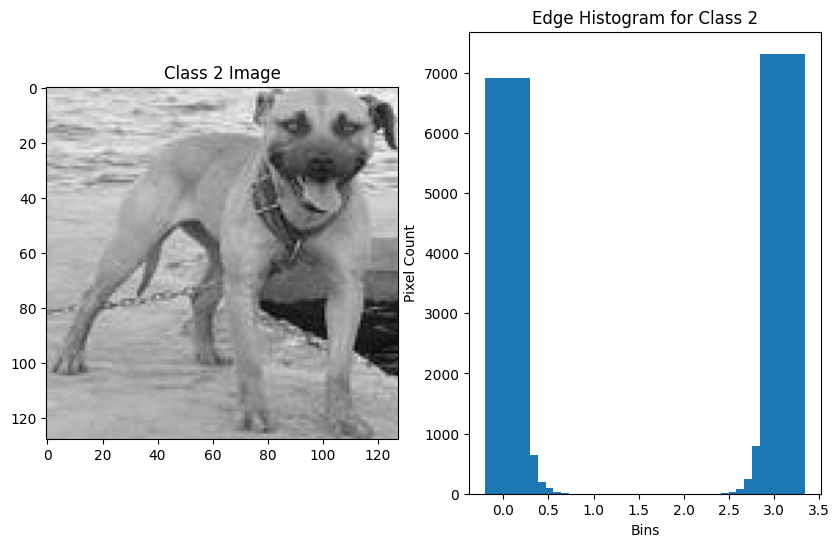

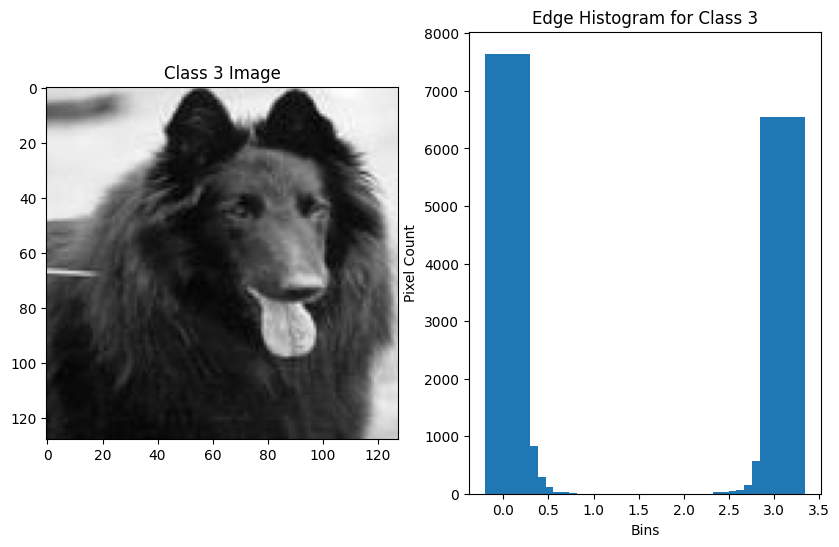

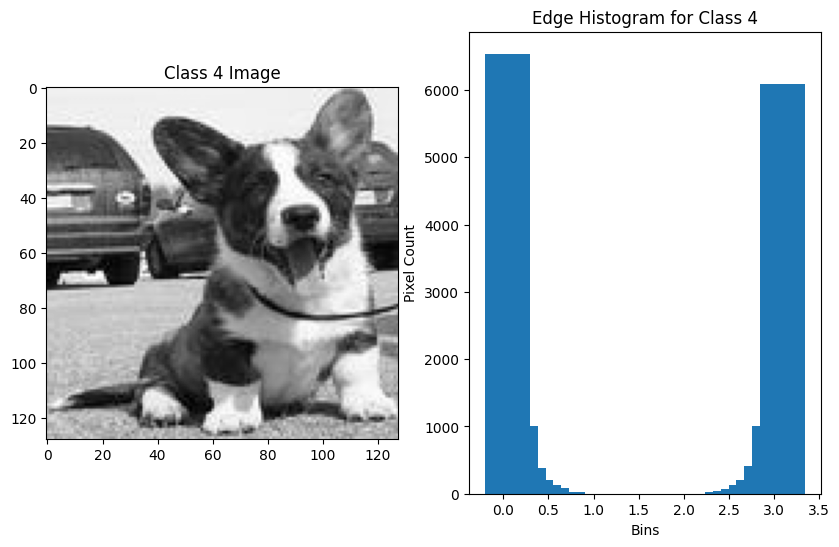

In [52]:
# iii. Obtain an "angle" for each pixel in the images
def angle(dx, dy):
    return np.mod(np.arctan(dy,dx), np.pi)

angles = []
for gray in grayscale:
    angle_sobel = angle(filters.sobel_h(gray),
                        filters.sobel_v(gray))
    angles.append(angle_sobel)

# iv. Obtain a histogram with 36 bins
histogram = []
for angle_sobel in angles:
    hist, bin_centers = exposure.histogram(angle_sobel, nbins=36)
    histogram.append((hist, bin_centers))

# v. Plot the images with corresponding edge histogram values
for i, (hist, bin_centers) in enumerate(histogram):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.imshow(grayscale[i], cmap=plt.cm.gray)
    plt.title(f"Class {i+1} Image")

    plt.subplot(1,2,2)
    plt.bar(bin_centers, hist, width=0.5)
    plt.xlabel("Bins")
    plt.ylabel("Pixel Count")
    plt.title(f"Edge Histogram for Class {i+1}")
    plt.show()
    

In [71]:
# vi. Pick 2 edge histograms constructed and perform histogram comparison between them

# Get the histogram and ignore the bin_centers
histogram_vectors = []
for hist, _ in histogram:
    histogram_vectors.append(hist)

# Picking 2 histograms
histvec1 = histogram_vectors[1]
histvec2 = histogram_vectors[3]

# Euclidean:
euc_distance = pairwise_distances([histvec1], [histvec2], metric='euclidean')
print(f"Euclidean Distance: {euc_distance[0][0]}")

# Manhattan:
man_distance = pairwise_distances([histvec1], [histvec2], metric='manhattan')
print(f"Manhattan Distance: {man_distance[0][0]}")

# Cosine:
cos_distance = pairwise_distances([histvec1], [histvec2], metric='cosine')
print(f"Cosine Distance: {cos_distance[0][0]}")

Euclidean Distance: 1391.0204887060436
Manhattan Distance: 3188.0
Cosine Distance: 0.004575385228500206


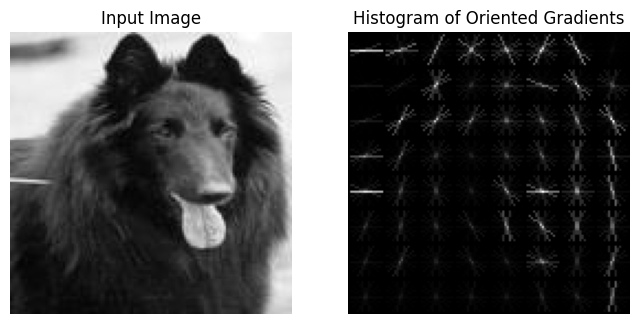

In [87]:
# (c) Histogram of Oriented Gradient (HOG)
# i. Pick one image and compute its HOG descriptors
image = grayscale[2]
fd, hog_image = hog(image, 
                    pixels_per_cell=(16,16), 
                    cells_per_block=(1,1),
                    visualize=True)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4),sharex=True,sharey=True)
ax1.axis('off')
ax1.imshow(image,cmap=plt.cm.gray)
ax1.set_title('Input Image')

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()


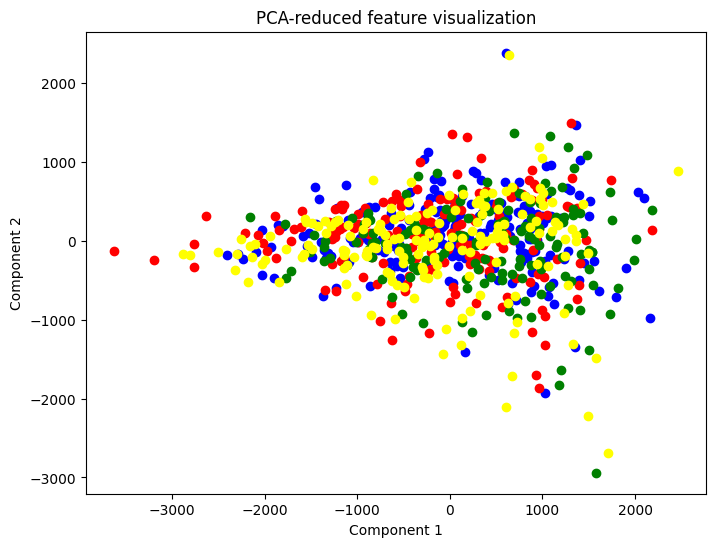

In [9]:
# (d) Dimensionality reduction using PCA

# ii. Convert all images from 4 classes to edge histograms
data_path = "./Processed_Data"
classes = ['n02085782-Japanese_spaniel', 
           'n02093428-American_Staffordshire_terrier', 
           'n02105056-groenendael', 
           'n02113186-Cardigan']
image_paths = []

# get all the paths
for classes_dir in classes:
    class_path = os.path.join(data_path, classes_dir)
    image_paths += [os.path.join(class_path, img) for img in os.listdir(class_path)]

histograms = []
gray_imgs = []

# convert images to grayscale
for img_path in image_paths:
    image = Image.open(img_path)
    image_array = np.array(image)
    gray = rgb2gray(image_array)
    gray_imgs.append(gray)

# same function from above copied down
def angle(dx, dy):
    return np.mod(np.arctan(dy,dx), np.pi)
    
angles = []
for gray in gray_imgs:
    angle_sobel = angle(filters.sobel_h(gray),
                        filters.sobel_v(gray))
    angles.append(angle_sobel)

# make a histogram with 36 bins
for angle_sobel in angles:
    hist, bin_centers = exposure.histogram(angle_sobel, nbins=36)
    histograms.append(hist)

edge_hist = np.array(histograms)

# iii. Perform PCA dimensionality reduction, reduce from 36 to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(edge_hist)

# iv. Plot 2D points using 4 different colors for data
colors = ['blue', 'red', 'green', 'yellow']
index = 0
plt.figure(figsize=(8,6))
for i, class_folder in enumerate(classes):
    class_len = len(os.listdir(os.path.join(data_path, class_folder)))
    plt.scatter(reduced_data[index:index+class_len, 0],
                reduced_data[index:index+class_len, 1],
                c=colors[i])
    index+= class_len

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("PCA-reduced feature visualization")
plt.show()

# iv. There does not seem to be any visually separable classes. They are all overlapping.

In [24]:
# 3. Next, we perform some text processing steps on a tweet (i.e., text) dataset
df = pd.read_json('10_train.json', lines=True)

# 4. Use countvectorizer and tfidfvectorizer to extract:
    # token counts
    # tfidf feature counts
x = df['Tweet']

count_vec = CountVectorizer()
tfidf_vec = TfidfVectorizer()
token_counts = count_vec.fit_transform(x)
tfidf_counts = tfidf_vec.fit_transform(x)

print("Token count dimensionality:", token_counts.shape)
print("TFIDF count dimensionality:", tfidf_counts.shape)

# What are the dimensionality of the two vector representations?
# Both dimensionalities of the vector representations are the same, meaning the same number of
# unique tokens (features) were extracted from the data.

Token count dimensionality: (3000, 9693)
TFIDF count dimensionality: (3000, 9693)


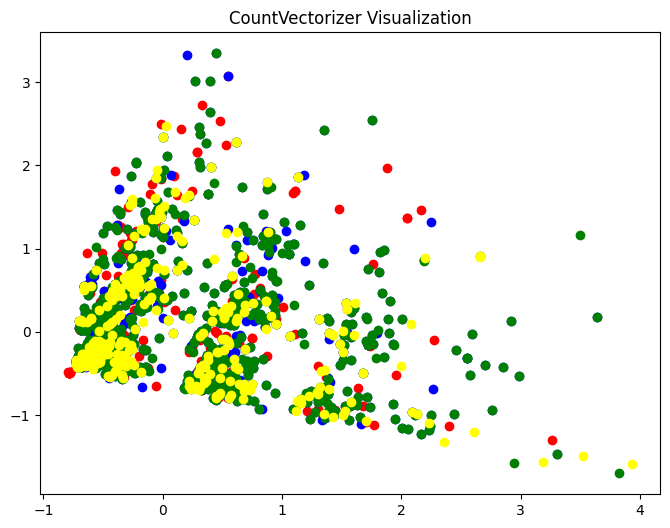

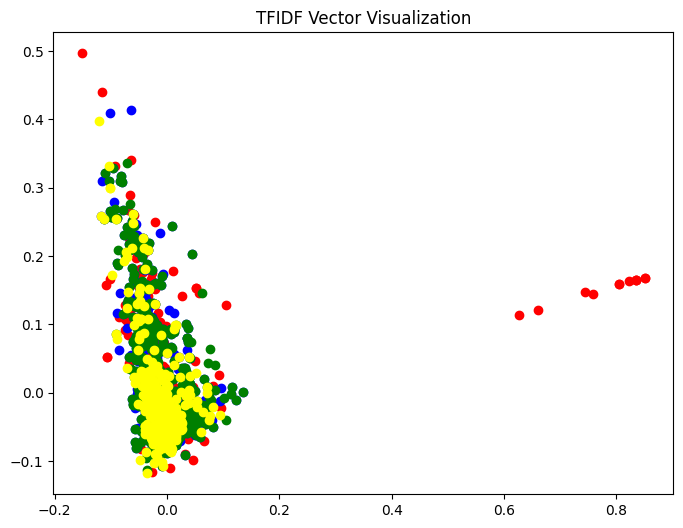

In [28]:
# 5. Using the two sets of processed text data from 4:

# Pick 4 classes you think will be separable
chosen_classes = ['love', 'anger', 'disgust', 'pessimism']
emotions = df[chosen_classes]

# Perform dimensionality reduction, reduced to 2
pca = PCA(n_components=2)
token_pca = pca.fit_transform(token_counts.toarray())
tfidf_pca = pca.fit_transform(tfidf_counts.toarray())

# Plot the 2d points using 4 different colors for data from 4 classes chosen, for
# both token count and tfidf count in two separate plots
colors = ['red', 'blue', 'green', 'yellow']

# Plot for countvectorizer
plt.figure(figsize=(8,6))
plt.scatter(token_pca[emotions['love'] == True, 0],
            token_pca[emotions['love'] == True, 1],
            c=colors[0])
plt.scatter(token_pca[emotions['anger'] == True, 0],
            token_pca[emotions['anger'] == True, 1],
            c=colors[1])
plt.scatter(token_pca[emotions['disgust'] == True, 0],
            token_pca[emotions['disgust'] == True, 1],
            c=colors[2])
plt.scatter(token_pca[emotions['pessimism'] == True, 0],
            token_pca[emotions['pessimism'] == True, 1],
            c=colors[3])
plt.title('CountVectorizer Visualization')
plt.show()

# Plot for tfidfvectorizer
plt.figure(figsize=(8,6))
plt.scatter(tfidf_pca[emotions['love'] == True, 0],
            tfidf_pca[emotions['love'] == True, 1],
            c=colors[0])
plt.scatter(tfidf_pca[emotions['anger'] == True, 0],
            tfidf_pca[emotions['anger'] == True, 1],
            c=colors[1])
plt.scatter(tfidf_pca[emotions['disgust'] == True, 0],
            tfidf_pca[emotions['disgust'] == True, 1],
            c=colors[2])
plt.scatter(tfidf_pca[emotions['pessimism'] == True, 0],
            tfidf_pca[emotions['pessimism'] == True, 1],
            c=colors[3])
plt.title('TFIDF Vector Visualization')
plt.show()

# How many classes are visually separable for both plots?
# None of the classes are non-overlapping for both the countvectorizer and the tfidf vectorizer.
# They both fully are overlapping with each other.